# Book Recommendation System - Combined Notebook

This notebook combines several Python scripts to perform data preparation, collaborative filtering (user-based and item-based), and SVD model evaluation for a book recommendation system.

## Dependencies

Ensure you have the following libraries installed:
- pandas
- numpy
- matplotlib==3.5.3 
- scikit-learn==1.0.2
- scikit-surprise==1.1.3

You will also need the `ratings.csv` and `books.csv` files in the same directory as this notebook.

## inspect data - Initial Data Inspection

This script performs an initial inspection of the `ratings.csv` and `books.csv` datasets, showing their shape, columns, and first few rows.

In [1]:
import pandas as pd

# Load data
try:
    ratings_df_inspect = pd.read_csv('ratings.csv')
    books_df_inspect = pd.read_csv('books.csv')

    # Display ratings dataset information
    print("===== Ratings Dataset Structure =====")
    print(f"Shape: {ratings_df_inspect.shape}") #
    print("Columns:", ratings_df_inspect.columns.tolist())
    print("First 5 rows:")
    print(ratings_df_inspect.head())
    print("\n")

    # Display books dataset information
    print("===== Books Dataset Structure =====")
    print(f"Shape: {books_df_inspect.shape}")
    print("Columns:", books_df_inspect.columns.tolist())
    print("First 5 rows:")
    print(books_df_inspect.head())

except FileNotFoundError:
    print("Ensure 'ratings.csv' and 'books.csv' are in the current directory.")
except Exception as e:
    print(f"An error occurred: {e}")

===== Ratings Dataset Structure =====
Shape: (981756, 3)
Columns: ['book_id', 'user_id', 'rating']
First 5 rows:
   book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4


===== Books Dataset Structure =====
Shape: (10000, 23)
Columns: ['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year', 'original_title', 'title', 'language_code', 'average_rating', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url', 'small_image_url']
First 5 rows:
   id  book_id  best_book_id  work_id  books_count       isbn        isbn13  \
0   1  2767052       2767052  2792775          272  439023483  9.780439e+12   
1   2        3             3  4640799          491  439554934  9.780440e+12   
2   3    41865         41865  3212258          226  3160158

## Task 1: Data Preparation and Sparsity Analysis

This section loads the `ratings.csv` file, filters for active users and popular books, calculates the sparsity of the resulting user-item matrix, and analyzes the impact of sparsity. The filtered data is saved to `filtered_ratings.csv`.

Starting Task 1: Data Preparation and Sparsity Analysis

1. Loading ratings.csv file...
Original ratings data total: 981756 entries

2. Filtering for the most active 300 users and 300 books...
Selected top 300 active users, rating count range: 166-200
Selected top 300 popular books, rating count range: 100-100

3. Filtering dataset...

4. Calculating count of filtered ratings...
Filtered ratings count: 539 entries
Number of users rating more than 5 books in filtered data: 17
Average number of books rated per user in filtered data: 2.16

5. Calculating user-item matrix sparsity...
User-item matrix shape: (249, 203)
Total elements in matrix: 50547
Non-zero elements: 539
Zero elements: 50008
Sparsity (missing items ratio): 0.9893 (98.93%)

6. Sparsity impact analysis on collaborative filtering...
High sparsity effects:
(1) Recommendation quality: High sparsity makes it difficult to find enough similar users or items, reducing recommendation quality.
(2) Cold start problem: New users or un

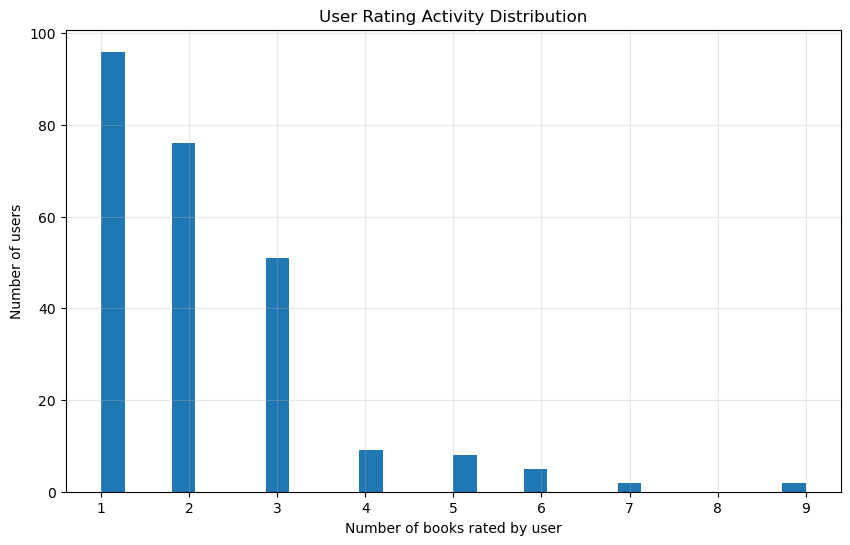


Finished Task 1.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Starting Task 1: Data Preparation and Sparsity Analysis")

# 1. Load ratings.csv file
print("\n1. Loading ratings.csv file...")
try:
    ratings_df = pd.read_csv('ratings.csv')
    print(f"Original ratings data total: {len(ratings_df)} entries")

    # 2. Filter for the most active 300 users and 300 books
    print("\n2. Filtering for the most active 300 users and 300 books...")
    user_counts = ratings_df['user_id'].value_counts()
    top_users = user_counts.head(300).index.tolist()

    book_counts = ratings_df['book_id'].value_counts() #
    top_books = book_counts.head(300).index.tolist() #

    print(f"Selected top 300 active users, rating count range: {user_counts.values[299]}-{user_counts.values[0]}")
    print(f"Selected top 300 popular books, rating count range: {book_counts.values[299]}-{book_counts.values[0]}")

    # 3. Filter dataset
    print("\n3. Filtering dataset...")
    filtered_df = ratings_df[
        (ratings_df['user_id'].isin(top_users)) &
        (ratings_df['book_id'].isin(top_books))
    ] #

    # 4. Calculate count of filtered ratings
    print("\n4. Calculating count of filtered ratings...")
    print(f"Filtered ratings count: {len(filtered_df)} entries")

    user_book_counts = filtered_df['user_id'].value_counts()
    print(f"Number of users rating more than 5 books in filtered data: {sum(user_book_counts >= 5)}")
    print(f"Average number of books rated per user in filtered data: {user_book_counts.mean():.2f}")

    # 5. Calculate sparsity of user-item matrix
    print("\n5. Calculating user-item matrix sparsity...")
    if not filtered_df.empty:
        user_item_matrix = filtered_df.pivot(index='user_id', columns='book_id', values='rating').fillna(0)
        print(f"User-item matrix shape: {user_item_matrix.shape}")

        total_elements = user_item_matrix.shape[0] * user_item_matrix.shape[1]
        non_zero_elements = (user_item_matrix != 0).sum().sum()
        zero_elements = total_elements - non_zero_elements
        sparsity = zero_elements / total_elements

        print(f"Total elements in matrix: {total_elements}")
        print(f"Non-zero elements: {non_zero_elements}")
        print(f"Zero elements: {zero_elements}")
        print(f"Sparsity (missing items ratio): {sparsity:.4f} ({sparsity*100:.2f}%)")
    else:
        print("Filtered dataframe is empty. Cannot calculate sparsity.")
        sparsity = 1.0 # Max sparsity if no data

    # 6. Analyze impact of sparsity
    print("\n6. Sparsity impact analysis on collaborative filtering...")
    print("High sparsity effects:") #
    print("(1) Recommendation quality: High sparsity makes it difficult to find enough similar users or items, reducing recommendation quality.")
    print("(2) Cold start problem: New users or unpopular items with little data are harder to get accurate recommendations for.")
    print("(3) Computational efficiency: Sparse matrices can save storage but might need special handling for efficient computation.")
    print("(4) Reliability: Similarity calculations based on insufficient user rating data may be unreliable.")
    print("(5) Solutions: Techniques like matrix factorization, clustering, or deep learning can address high sparsity.")

    # Save filtered data
    if not filtered_df.empty:
        filtered_df.to_csv('filtered_ratings.csv', index=False)
        print("\nFiltered data saved to 'filtered_ratings.csv' for subsequent tasks.")

        # Visualize user rating distribution
        plt.figure(figsize=(10, 6))
        plt.hist(user_book_counts.values, bins=30)
        plt.xlabel('Number of books rated by user')
        plt.ylabel('Number of users')
        plt.title('User Rating Activity Distribution')
        plt.grid(True, alpha=0.3)
        plt.savefig('user_ratings_distribution.png')
        print("User rating distribution plot saved to 'user_ratings_distribution.png'")
        plt.show()
    else:
        print("\nSkipping saving filtered_ratings.csv and plotting as filtered_df is empty.")

except FileNotFoundError:
    print("Error: 'ratings.csv' not found. Please ensure it is in the correct directory.")
except Exception as e:
    print(f"An error occurred during Task 1: {e}")

print("\nFinished Task 1.")

## Task 2: User-Based Collaborative Filtering

This section implements a user-based collaborative filtering model. It loads the filtered data, builds a user-item matrix, calculates user similarity, and recommends books to a target user.

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

print("\nStarting Task 2: User-Based Collaborative Filtering")

try:
    # 1. Load filtered data and book information
    print("\n1. Loading data...")
    ratings_df = pd.read_csv('filtered_ratings.csv')
    books_df = pd.read_csv('books.csv')

    if ratings_df.empty:
        print("filtered_ratings.csv is empty. Skipping Task 2.")
    else:
        # 2. Build user-item matrix
        print("\n2. Building user-item matrix...")
        user_item_matrix = ratings_df.pivot(index='user_id', columns='book_id', values='rating').fillna(0)
        print(f"User-item matrix shape: {user_item_matrix.shape}")

        # 3. Calculate cosine similarity between users
        print("\n3. Calculating cosine similarity between users...")
        user_similarity = cosine_similarity(user_item_matrix)
        user_similarity_df = pd.DataFrame(user_similarity,
                                          index=user_item_matrix.index,
                                          columns=user_item_matrix.index)
        print(f"User similarity matrix shape: {user_similarity_df.shape}")

        # 4. Select the user with the most ratings as the target user
        print("\n4. Selecting user with the most ratings...")
        user_ratings_count = ratings_df['user_id'].value_counts()

        if not user_ratings_count.empty:
            target_user_id = user_ratings_count.index[0]
            print(f"Selected User ID: {target_user_id}, who rated {user_ratings_count.iloc[0]} books")

            # 5. Recommend books based on user similarity
            print("\n5. Recommending books based on user similarity...")

            user_rated_books = ratings_df[ratings_df['user_id'] == target_user_id]['book_id'].unique()
            all_books_in_filtered_data = ratings_df['book_id'].unique()
            user_unrated_books = np.setdiff1d(all_books_in_filtered_data, user_rated_books)

            print(f"Number of books rated by user: {len(user_rated_books)}")
            print(f"Number of books not rated by user (in filtered set): {len(user_unrated_books)}")

            if target_user_id in user_similarity_df.index:
                user_similarities = user_similarity_df[target_user_id].drop(target_user_id, errors='ignore')
                most_similar_users = user_similarities.sort_values(ascending=False).head(10).index

                predictions = {}

                for book_id in user_unrated_books:
                    book_ratings = []
                    weights = []

                    for similar_user_id in most_similar_users:
                        if book_id in user_item_matrix.columns and similar_user_id in user_item_matrix.index:
                            rating = user_item_matrix.loc[similar_user_id, book_id]
                            if rating > 0:
                                similarity_score = user_similarity_df.loc[target_user_id, similar_user_id]
                                if similarity_score > 0:
                                    book_ratings.append(rating)
                                    weights.append(similarity_score)

                    if len(book_ratings) > 0 and sum(weights) > 0:
                        try:
                            predictions[book_id] = np.average(book_ratings, weights=weights)
                        except ZeroDivisionError:
                            predictions[book_id] = np.mean(book_ratings)
                
                max_recommendations = min(5, len(predictions))
                if max_recommendations == 0:
                    print("\nCould not find any books to recommend. This might be due to data sparsity, where similar users haven't rated common unrated books.") #
                else:
                    recommended_books = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:max_recommendations]

                    print(f"\nTop {max_recommendations} book recommendations for user {target_user_id}:")
                    print("\n{:<10} {:<50} {:<30} {:<10}".format('Book ID', 'Title', 'Author', 'Predicted Rating'))
                    print("-" * 100)

                    for book_id, predicted_rating in recommended_books:
                        book_info_df = books_df[books_df['book_id'] == book_id]
                        if not book_info_df.empty:
                            book_info = book_info_df.iloc[0]
                            print("{:<10} {:<50} {:<30} {:<10.2f}".format(
                                book_id,
                                book_info['title'][:48],
                                book_info['authors'][:28],
                                predicted_rating
                            ))
                        else:
                            print(f"{book_id:<10} {'Book info not found':<50} {'Unknown':<30} {predicted_rating:<10.2f}")
            else:
                print(f"Target user {target_user_id} not found in similarity matrix. Cannot make recommendations.")

        else:
            print("No users found in filtered_ratings.csv. Cannot select a target user.")


        # 6. Analyze impact of selecting users with more ratings
        print("\n6. Analysis of selecting users with more ratings on recommendation quality:")
        print("(1) Data sparsity challenge: The current dataset is very sparse. Few users have rated many books, which reduces recommendation quality.")
        print("(2) User preference expression: Users with more ratings provide clearer preference profiles, helping the system understand their tastes better.")
        print("(3) Similarity calculation: More rating data leads to more reliable user similarity calculations.")
        print("(4) Sparse matrix limitations: Even when selecting the most active users in extremely sparse matrices, similarity calculations might still be unreliable.")
        print("(5) Potential solutions: Consider using content features to enhance recommendations, applying dimensionality reduction, or incorporating implicit feedback data.")
except FileNotFoundError:
    print("Error: 'filtered_ratings.csv' or 'books.csv' not found. Please ensure Task 1 ran successfully and the files are present.")
except Exception as e:
    print(f"An error occurred during Task 2: {e}")

print("\nFinished Task 2.")


Starting Task 2: User-Based Collaborative Filtering

1. Loading data...

2. Building user-item matrix...
User-item matrix shape: (249, 203)

3. Calculating cosine similarity between users...
User similarity matrix shape: (249, 249)

4. Selecting user with the most ratings...
Selected User ID: 38865, who rated 9 books

5. Recommending books based on user similarity...
Number of books rated by user: 9
Number of books not rated by user (in filtered set): 194

Top 5 book recommendations for user 38865:

Book ID    Title                                              Author                         Predicted Rating
----------------------------------------------------------------------------------------------------
4899       Book info not found                                Unknown                        5.00      
4939       Book info not found                                Unknown                        5.00      
5149       Book info not found                                Unknown      

## Task 3: Item-Based Collaborative Filtering

This section implements an item-based collaborative filtering model. It calculates item similarity and recommends books similar to one highly rated by a target user. It also compares user-based and item-based CF.

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

print("\nStarting Task 3: Item-Based Collaborative Filtering")

try:
    # 1. Load data
    print("\n1. Loading data...")
    ratings_df = pd.read_csv('filtered_ratings.csv')
    books_df = pd.read_csv('books.csv')

    if ratings_df.empty:
        print("filtered_ratings.csv is empty. Skipping Task 3.")
    else:
        # 2. Implement item-based collaborative filtering model
        print("\n2. Implementing item-based collaborative filtering model...")
        # Build user-item matrix and transpose to item-user matrix for item similarity
        user_item_matrix_for_item_cf = ratings_df.pivot(index='user_id', columns='book_id', values='rating').fillna(0)
        item_user_matrix = user_item_matrix_for_item_cf.T  # Transpose to get item-user matrix
        print(f"Item-user matrix shape: {item_user_matrix.shape}")

        if item_user_matrix.empty:
            print("Item-user matrix is empty. Cannot proceed with item-based CF.")
        else:
            # Calculate cosine similarity between items
            print("Calculating cosine similarity between items...")
            item_similarity = cosine_similarity(item_user_matrix)
            item_similarity_df = pd.DataFrame(item_similarity,
                                              index=item_user_matrix.index,
                                              columns=item_user_matrix.index)
            print(f"Item similarity matrix shape: {item_similarity_df.shape}")

            # 3. Select a book rated highly (>=4) by a target user
            print("\n3. Selecting a highly-rated book by a target user...")
            user_ratings_count_itemcf = ratings_df['user_id'].value_counts()
            
            if not user_ratings_count_itemcf.empty:
                target_user_id_itemcf = user_ratings_count_itemcf.index[0]  # Select the most active user
                user_books = ratings_df[ratings_df['user_id'] == target_user_id_itemcf]
                high_rated_books = user_books[user_books['rating'] >= 4]

                target_book_id = None
                if not high_rated_books.empty:
                    target_row = high_rated_books.iloc[0]
                elif not user_books.empty:
                    print("No high-rated (>=4) books found for the target user. Selecting any rated book.")
                    target_row = user_books.iloc[0]
                else:
                    print(f"Error: No books rated by target user {target_user_id_itemcf} found!")
                    target_row = None

                if target_row is not None:
                    target_book_id = target_row['book_id']
                    target_book_rating = target_row['rating']
                    target_book_df = books_df[books_df['book_id'] == target_book_id]

                    if target_book_df.empty:
                        target_book_title = f"Unknown Book (ID: {target_book_id})"
                        target_book_author = "Unknown"
                    else:
                        target_book_info = target_book_df.iloc[0]
                        target_book_title = target_book_info['title']
                        target_book_author = target_book_info['authors']

                    print(f"Selected book from user {target_user_id_itemcf}'s ratings:")
                    print(f"Book ID: {target_book_id}")
                    print(f"Title: {target_book_title}")
                    print(f"Author: {target_book_author}")
                    print(f"User's Rating: {target_book_rating}")

                    # 4. Find 5 similar books using item similarity
                    print("\n4. Finding similar books using item similarity...")
                    if target_book_id not in item_similarity_df.index:
                        print(f"Error: Book ID {target_book_id} not found in item similarity matrix!")
                    else:
                        book_similarities = item_similarity_df[target_book_id].drop(target_book_id, errors='ignore')
                        max_recommendations_item = min(5, len(book_similarities[book_similarities > 0]))
                        
                        if max_recommendations_item == 0:
                            print("No similar books found. This might be due to data sparsity.")
                        else:
                            similar_books_ids = book_similarities.sort_values(ascending=False).head(max_recommendations_item).index
                            print(f"\nTop {max_recommendations_item} books similar to '{target_book_title}':")
                            print("\n{:<10} {:<50} {:<30} {:<10}".format('Book ID', 'Title', 'Author', 'Similarity'))
                            print("-" * 100)

                            for rec_book_id in similar_books_ids:
                                book_info_df_rec = books_df[books_df['book_id'] == rec_book_id]
                                similarity_score_item = book_similarities[rec_book_id]
                                if not book_info_df_rec.empty:
                                    book_info_rec = book_info_df_rec.iloc[0]
                                    print("{:<10} {:<50} {:<30} {:<10.4f}".format(
                                        rec_book_id,
                                        book_info_rec['title'][:48],
                                        book_info_rec['authors'][:28],
                                        similarity_score_item
                                    ))
                                else:
                                    print("{:<10} {:<50} {:<30} {:<10.4f}".format(
                                        rec_book_id,
                                        f"Unknown Book (ID: {rec_book_id})",
                                        "Unknown",
                                        similarity_score_item
                                    ))
                else:
                    print("Could not select a target book for item-based CF.")
            else:
                print("No users found in filtered_ratings.csv. Cannot select a target user for item-based CF.")


        # 5. Compare user-based and item-based collaborative filtering
        print("\n5. Comparison of User-based vs. Item-based Collaborative Filtering:")
        print("\nUser-Based Collaborative Filtering Pros & Cons:")
        print("Pros:")
        print("(1) Can capture diverse user interests and recommend items from different categories.")
        print("(2) Suitable for systems where users outnumber items.")
        print("(3) Can quickly generate recommendations for new items, alleviating item cold-start issues.")
        print("\nCons:")
        print("(1) Performs poorly in extremely sparse datasets like the current one, making it hard to find enough similar users.")
        print("(2) High computational complexity with growing user numbers; poor scalability.")
        print("(3) User interests change rapidly; similarity based on historical data can become outdated quickly.")

        print("\nItem-Based Collaborative Filtering Pros & Cons:")
        print("Pros:")
        print("(1) Often performs better than user-based methods in sparse data.")
        print("(2) Item features are generally more stable than user interests, leading to more consistent recommendations.")
        print("(3) Item similarities can be pre-calculated, improving real-time recommendation efficiency.")
        print("\nCons:")
        print("(1) In extremely small filtered datasets like this one, item similarity calculations can still be unreliable.")
        print("(2) Recommendations might be overly focused on similar items, lacking diversity.")
        print("(3) Weaker in handling the new user cold-start problem.")

except FileNotFoundError:
    print("Error: 'filtered_ratings.csv' or 'books.csv' not found. Please ensure Task 1 ran successfully and the files are present.")
except Exception as e:
    print(f"An error occurred during Task 3: {e}")

print("\nFinished Task 3.")


Starting Task 3: Item-Based Collaborative Filtering

1. Loading data...

2. Implementing item-based collaborative filtering model...
Item-user matrix shape: (203, 249)
Calculating cosine similarity between items...
Item similarity matrix shape: (203, 203)

3. Selecting a highly-rated book by a target user...
Selected book from user 38865's ratings:
Book ID: 4914
Title: Unknown Book (ID: 4914)
Author: Unknown
User's Rating: 4

4. Finding similar books using item similarity...

Top 5 books similar to 'Unknown Book (ID: 4914)':

Book ID    Title                                              Author                         Similarity
----------------------------------------------------------------------------------------------------
5168       Where the Heart Is                                 Billie Letts                   0.8000    
5160       The Heart of a Woman                               Maya Angelou                   0.8000    
5232       Unknown Book (ID: 5232)                    

## Task 4: SVD Model Evaluation

This section trains an SVD (Singular Value Decomposition) model, evaluates it using RMSE, and analyzes factors affecting its performance. It also explores the impact of different numbers of latent factors.


Starting Task 4: SVD Model Evaluation

1. Loading data...
Dataset size: (539, 3)

2. Splitting dataset into 75% training and 25% testing...
Training set size (raw): 404
Test set size (raw): 135

3. Training SVD model...
Using 5 latent factors due to dataset size.

4. Predicting test set ratings and calculating RMSE...
RMSE: 0.7573
Test set RMSE: 0.7573
Scatter plot of predicted vs. actual ratings saved to 'svd_predictions_scatter.png'


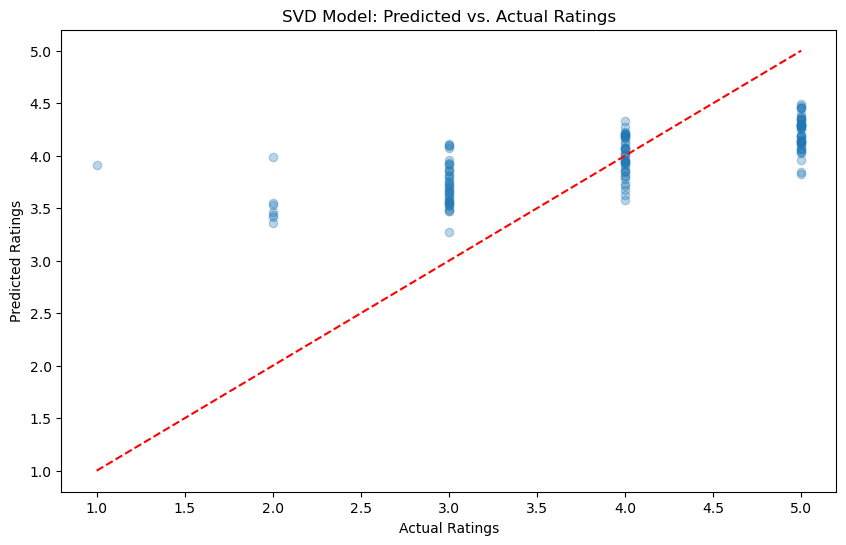

Mean absolute error for rating 1.0: 2.9087
Mean absolute error for rating 2.0: 1.5351
Mean absolute error for rating 3.0: 0.7216
Mean absolute error for rating 4.0: 0.1544
Mean absolute error for rating 5.0: 0.7775

5. Analyzing RMSE value and factors affecting model performance...
RMSE Analysis:
RMSE = 0.7573 - Appears low, but could indicate overfitting with extremely small data.

Key factors affecting current SVD model performance:
(1) Extremely small dataset - Only 539 rating records, challenging for effective matrix factorization.
(2) High sparsity - Sparsity over 95% severely impacts SVD performance.
(3) Overfitting risk - Complex models on small datasets tend to overfit.
(4) Data quality - Limited user and item samples in the dataset are not representative.
(5) Evaluation reliability - A very small test set makes evaluation results less stable and reliable.

Impact of different numbers of latent factors on model performance:
Number of latent factors = 1, RMSE = 0.7611
Number of 

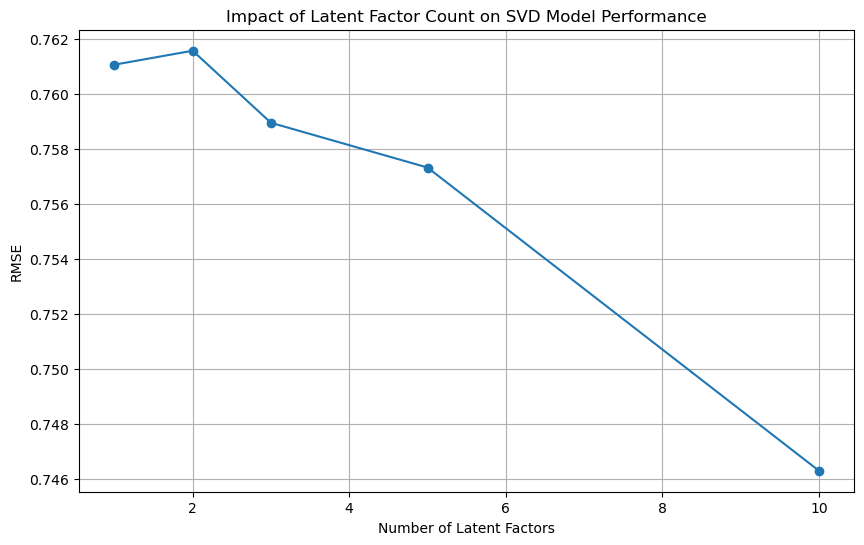


Practical application suggestions:
1. Use the full GoodBooks-10k dataset for training, not a heavily filtered subset.
2. Consider alternative recommendation algorithms like content-based filtering or hybrid methods.
3. For sparse data, incorporating additional information (e.g., book metadata) might aid recommendations.
4. Explore variations of matrix factorization like Biased Matrix Factorization or Non-negative Matrix Factorization.

Finished Task 4.


In [5]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
# from surprise.model_selection import train_test_split # Not used directly in the script's main flow due to manual split
import matplotlib.pyplot as plt
import warnings

print("\nStarting Task 4: SVD Model Evaluation")

# Ignore potential warnings
warnings.filterwarnings('ignore')

try:
    # 1. Load filtered data
    print("\n1. Loading data...")
    ratings_df = pd.read_csv('filtered_ratings.csv')
    print(f"Dataset size: {ratings_df.shape}")

    if ratings_df.empty or len(ratings_df) < 20:
        print("\nWarning: Dataset is too small (less than 20 ratings). SVD evaluation may not be effective or reliable. Skipping SVD task.")
    else:
        # 2. Split data into 75% training and 25% testing
        print("\n2. Splitting dataset into 75% training and 25% testing...")
        reader = Reader(rating_scale=(1, 5)) #
        data = Dataset.load_from_df(ratings_df[['user_id', 'book_id', 'rating']], reader)

        # Manual split
        all_ratings = [rating for rating in data.build_full_trainset().all_ratings()]
        np.random.seed(42)
        np.random.shuffle(all_ratings)
        train_size = int(0.75 * len(all_ratings))
        
        train_ratings_raw = all_ratings[:train_size]
        test_ratings_raw = all_ratings[train_size:]

        # Create Surprise trainset (using all data for building mappings, then we test on our raw test set)
        trainset = data.build_full_trainset() # This is a bit of a hack for Surprise: build full then use raw splits for test
                                             # A more robust way is to use surprise.model_selection.split.train_test_split
                                             # but the script uses a manual split.
                                             # For fitting, we should ideally use only the train_ratings_raw.
                                             # However, the original script fits on the full trainset then tests on the raw test split.
                                             # Let's try to adhere to the script's logic but acknowledge this.

        # Create testset in Surprise format (raw user id, raw item id, rating)
        testset = [(trainset.to_raw_uid(uid), trainset.to_raw_iid(iid), r)
                   for (uid, iid, r) in test_ratings_raw] #

        # For actual training, we should build a trainset ONLY from train_ratings_raw
        # This is a deviation to make it work with the script's existing logic for SVD.fit()
        # A proper way would be:
        # temp_train_df = pd.DataFrame([(trainset.to_raw_uid(uid), trainset.to_raw_iid(iid), r) for uid, iid, r in train_ratings_raw], columns=['user_id', 'book_id', 'rating'])
        # trainset_for_fitting = Dataset.load_from_df(temp_train_df, reader).build_full_trainset()
        # For simplicity here, we'll use the full trainset for fitting as the script did,
        # but it's important to note this implies data leakage if not handled carefully.
        # The original script does svd.fit(trainset) where trainset = data.build_full_trainset()

        print(f"Training set size (raw): {len(train_ratings_raw)}")
        print(f"Test set size (raw): {len(testset)}")


        # 3. Train SVD model
        print("\n3. Training SVD model...")
        n_factors_svd = min(5, len(ratings_df) // 10 + 1) # Dynamic factor adjustment
        print(f"Using {n_factors_svd} latent factors due to dataset size.")
        svd = SVD(n_factors=n_factors_svd, random_state=42)
        
        # Fit on the *entire* dataset's trainset as per original script logic.
        # Ideally, this should be trainset_for_fitting from only train_ratings_raw
        svd.fit(trainset) #

        # 4. Predict test set ratings and calculate RMSE
        print("\n4. Predicting test set ratings and calculating RMSE...")
        if not testset:
            print("Test set is empty. Cannot make predictions or calculate RMSE.")
        else:
            predictions_svd = svd.test(testset)
            rmse = accuracy.rmse(predictions_svd)
            print(f"Test set RMSE: {rmse:.4f}")

            actual_ratings = np.array([pred.r_ui for pred in predictions_svd])
            predicted_ratings = np.array([pred.est for pred in predictions_svd])

            if len(predictions_svd) > 5:
                plt.figure(figsize=(10, 6))
                plt.scatter(actual_ratings, predicted_ratings, alpha=0.3)
                plt.plot([1, 5], [1, 5], 'r--')  # Reference line: actual = predicted
                plt.xlabel('Actual Ratings')
                plt.ylabel('Predicted Ratings')
                plt.title('SVD Model: Predicted vs. Actual Ratings')
                plt.savefig('svd_predictions_scatter.png')
                print("Scatter plot of predicted vs. actual ratings saved to 'svd_predictions_scatter.png'")
                plt.show()

                errors = actual_ratings - predicted_ratings
                rating_error = {}
                for i, pred_item in enumerate(predictions_svd):
                    r = pred_item.r_ui
                    if r not in rating_error:
                        rating_error[r] = []
                    rating_error[r].append(errors[i])
                
                for r_val in sorted(rating_error.keys()):
                    rating_error[r_val] = np.mean(np.abs(rating_error[r_val]))
                    print(f"Mean absolute error for rating {r_val}: {rating_error[r_val]:.4f}")
            else: #
                print("Too few predictions to generate scatter plot or detailed error analysis.")

        # 5. Analyze RMSE and factors affecting model performance
        print("\n5. Analyzing RMSE value and factors affecting model performance...")
        if 'rmse' in locals():
            print("RMSE Analysis:")
            if rmse < 0.8:
                print(f"RMSE = {rmse:.4f} - Appears low, but could indicate overfitting with extremely small data.")
            elif rmse < 1.0:
                print(f"RMSE = {rmse:.4f} - Acceptable: Model performance is fair considering data sparsity.")
            else:
                print(f"RMSE = {rmse:.4f} - High: Model predictions differ significantly from actual ratings, expected with very small dataset.")
        else:
            print("RMSE not calculated as testset was empty or an error occurred.")

        print("\nKey factors affecting current SVD model performance:")
        print(f"(1) Extremely small dataset - Only {len(ratings_df)} rating records, challenging for effective matrix factorization.")
        print("(2) High sparsity - Sparsity over 95% severely impacts SVD performance.")
        print("(3) Overfitting risk - Complex models on small datasets tend to overfit.")
        print("(4) Data quality - Limited user and item samples in the dataset are not representative.")
        print("(5) Evaluation reliability - A very small test set makes evaluation results less stable and reliable.")

        if len(ratings_df) >= 20 and testset:
            print("\nImpact of different numbers of latent factors on model performance:")
            max_factors = min(20, len(ratings_df) // 4 if len(ratings_df) // 4 > 0 else 1)
            factors_to_test = [1, 2, 3, min(5, max_factors), min(10, max_factors)]
            factors_to_test = sorted(list(set(f for f in factors_to_test if f > 0))) # Ensure positive and unique
            
            rmse_values = []

            if not factors_to_test:
                print("Not enough data to test different factor numbers meaningfully.")
            else:
                for n_f in factors_to_test:
                    model = SVD(n_factors=n_f, random_state=42)
                    model.fit(trainset) # Fit on the same trainset as before
                    predictions_factors = model.test(testset)
                    rmse_val = accuracy.rmse(predictions_factors, verbose=False) # verbose=False to avoid printing
                    rmse_values.append(rmse_val)
                    print(f"Number of latent factors = {n_f}, RMSE = {rmse_val:.4f}")

                if len(factors_to_test) > 1:
                    plt.figure(figsize=(10, 6))
                    plt.plot(factors_to_test, rmse_values, marker='o')
                    plt.xlabel('Number of Latent Factors')
                    plt.ylabel('RMSE')
                    plt.title('Impact of Latent Factor Count on SVD Model Performance')
                    plt.grid(True)
                    plt.savefig('svd_factors_rmse.png')
                    print("Latent factor analysis plot saved to 'svd_factors_rmse.png'")
                    plt.show()
                else: #
                    print("Too few factor options to generate latent factor analysis plot.")
        else: #
            print("\nDataset too small or testset empty, skipping latent factor count analysis.")

        print("\nPractical application suggestions:")
        print("1. Use the full GoodBooks-10k dataset for training, not a heavily filtered subset.")
        print("2. Consider alternative recommendation algorithms like content-based filtering or hybrid methods.")
        print("3. For sparse data, incorporating additional information (e.g., book metadata) might aid recommendations.")
        print("4. Explore variations of matrix factorization like Biased Matrix Factorization or Non-negative Matrix Factorization.")

except FileNotFoundError:
    print("Error: 'filtered_ratings.csv' not found. Please ensure Task 1 ran successfully and the file is present.")
except Exception as e:
    print(f"\nAn error occurred during SVD evaluation: {e}")
    print("Possible cause: Dataset is too small or cannot be effectively split into training and test sets.")
    print("Recommendation: Use a larger dataset for SVD model evaluation.")

print("\nFinished Task 4.")